In [39]:
### A Pluto.jl notebook ###
# v0.19.36

using Markdown
using InteractiveUtils

In [40]:
] activate "/sps/nemo/scratch/mpetro/Projects/SNSensitivityEstimate/"

  Activating project at `/sps/nemo/scratch/mpetro/Projects/SNSensitivityEstimate`


In [85]:
# ] instantiate;

In [42]:
using DrWatson

In [43]:
@quickactivate "SensitivityEstimate"

In [44]:
begin
    using StatsPlots, UnROOT, DataFramesMeta, LaTeXStrings, Revise, StatsBase, FHist, Measurements, PrettyTables
    push!(LOAD_PATH, srcdir())
    using SensitivityModule
    include(scriptsdir("Params.jl"))
    
    nothing
end

Dict{Symbol, Any} with 8 entries:
  :isotopeName    => "Xi037_foil_bulk"
  :activity       => 0.0015±0.0001
  :nTotalSim      => 1.0e8
  :timeMeas       => 7.884e7
  :vertexPosition => "foil_bulk"
  :amount         => 6.25
  :signal         => true
  :bins           => 0:5:180

In [45]:
begin 
    _palette = ["#00a0f9", "#ba3030", "#22ac74", "#707070", "#9452bd", "#80ff00", "#ffcc00", "#ff00ff", "#00ffff", "#cc9900", "#2a2727"]
    theme(
        :dao;
        size = (1200, 800),
        legend = :best,
        guidefontsize = 16,
        tickfontsize = 12,
        titlefontsize = 16,
        legendfontsize = 12,
        left_margin = 4Plots.mm,
        right_margin = 8Plots.mm,
        top_margin = 4Plots.mm,
        bottom_margin = 6Plots.mm,
        thickness_scaling = 1.4,
        :linewidth => 3,
        dpi = 200,
        widen = :false,
        :markerstrokewidth => 1,
        :markerstrokecolor => :black,
        :palette => _palette
    )
end

 
### First we load all the `.root` input simulation files:
1. **Background processes** : 
+ Bi214 foil bulk SumE
+ Bi214 foil surface SumE
+ Bi214 PMT bulk SumE
+ Bi214 wire bulk SumE
+ Bi214 wire surface SumE
+ Tl208 foil bulk SumE
+ Tl208 PMT bulk SumE
+ Pa234m foil bulk SumE
+ K40 foil bulk SumE
+ K40 PMT bulk SumE
2. **Signal process**:
> *refined spectrum $\xi_{31}, \xi_{51}$* with the following parameters:
- ``\xi_{31} = 0.37``
- ``\xi_{51} = 0.14``
- ``K^{2\nu} = -0.66``
 

In [47]:
# hack for quick fill from root
ffrf(file) = fill_from_root_file(file, "tree", ["phi", "reconstructedEnergy1", "reconstructedEnergy2"] ) 

ffrf (generic function with 1 method)

In [48]:
begin
#Bi214
    Bi214_foil_bulk = 
        ROOTFile(datadir("sims/Bi214_foil_bulk_1e8E.root")) |> ffrf
    Bi214_foil_surface = 
        ROOTFile(datadir("sims/Bi214_foil_surface_1e7E.root")) |> ffrf
    Bi214_PMT_bulk = 
        ROOTFile(datadir("sims/Bi214_PMT_bulk_1e7E.root")) |> ffrf
    Bi214_wire_bulk = 
        ROOTFile(datadir("sims/Bi214_wire_bulk_1e7E.root")) |> ffrf
    Bi214_wire_surface = 
        ROOTFile(datadir("sims/Bi214_wire_surface_1e7E.root")) |> ffrf

#Tl208
    Tl208_foil_bulk = 
        ROOTFile(datadir("sims/Tl208_foil_bulk_1e8E.root")) |> ffrf
    Tl208_PMT_bulk = 
        ROOTFile(datadir("sims/Tl208_PMT_bulk_1e8E.root")) |> ffrf

#Pa234m
    Pa234m_foil_bulk = 
        ROOTFile(datadir("sims/Pa234m_foil_bulk_1e8E.root")) |> ffrf

#K40
    K40_foil_bulk = 
        ROOTFile(datadir("sims/K40_foil_bulk_1e8E.root")) |> ffrf
    K40_PMT_bulk = 
        ROOTFile(datadir("sims/K40_PMT_bulk_1e8E.root")) |> ffrf

#Xi31
    Xi037_foil_bulk = 
        ROOTFile(datadir("sims/Xi037_foil_bulk_1e8E.root")) |> ffrf 
end

8240117×3 DataFrame
     Row │ reconstructedEnergy2  reconstructedEnergy1  phi      
         │ Float32               Float32               Float32  
─────────┼──────────────────────────────────────────────────────
       1 │              978.629               141.823   91.9659
       2 │              353.124               897.696  138.051
       3 │              772.878              1080.25   129.36
       4 │              614.549              1075.65    69.5691
       5 │              714.981               172.517   22.4111
       6 │              497.665               456.098   15.5818
       7 │              352.436               465.499   99.5599
       8 │              418.158               608.005   91.5183
       9 │              874.786               263.201   72.1372
      10 │              925.715               405.297  146.289
      11 │              375.19               1580.31   169.873
    ⋮    │          ⋮                     ⋮               ⋮
 8240108 │              317.347               717.974   81.4327
 8240109 │              176.346               860.312  102.552
 8240110 │              999.066               333.65    30.2827
 8240111 │              549.21                442.715  117.502
 8240112 │              462.316               776.617  125.858
 8240113 │              447.751               413.335  138.767
 8240114 │              719.642               363.327   66.544
 8240115 │             1074.17                794.531  171.751
 8240116 │              330.011               918.989   75.9197
 8240117 │              503.707               504.553  157.208
                                            8240096 rows omitted

 
### Now we transform the raw inptu data into `DataFrame` format for easier handling.
Here we also import only three variables: ``E_1``, ``E_2`` and ``\phi``
 

In [80]:
md"""

### Next we import all the important parameters for the analysis. 
The import itself has already been done in the 3rd cell by the `include(scriptsdit("Params.jl"))` command. Now we analyse what's inside.

The file `Params.jl` contains all the input constants that will be used in the analysis. These are divided into groups:
* **Detector Parameters** (Dict variable `SNParams`): 
  * Nₐ = $(SNparams["Nₐ"]) ``\rightarrow`` Avogadro's number in [1/mol]
  * W = $(SNparams["W"]) ``\rightarrow`` Se82 molar mass in [kg/mol]
  * a = $(SNparams["a"]) ``\rightarrow`` abundance/foil enrichment; check number
  * foilMass = $(SNparams["foilMass"]) ``\rightarrow`` foil mass in [kg]
  * PMTGlassMass => $(SNparams["PMTGlassMass"]) ``\rightarrow`` PMT glass mass in [kg]
  * wireBulkMass = $(SNparams["wireBulkMass"]) ``\rightarrow`` DUMMY VALUE!! mass of the tracker wires in [kg]
  * t = $(SNparams["t"]) ``\rightarrow`` measurement time in [s]
  * tYear = $(SNparams["tYear"]) ``\rightarrow`` measurement time in [y]
  * SeThalf =  $(round(SNparams["SeThalf"], sigdigits = 4)) ``\rightarrow`` Se82 half life **in [s]**, results from NEMO-3

* **Activity Parameters** (Dict variables `BkgActivityParams` and `SigActivityParams`):
  * **Background** (Taken from NEMO-3 paper, SN measurements, presentations, mock)
    * :Bi214 foil bulk => $(BkgActivityParams[:Bi214_foil_bulk]) Bq/kg
    * :Tl208 foil bulk => $(BkgActivityParams[:Tl208_foil_bulk]) Bq/kg
    * :Pa234m foil bulk => $(BkgActivityParams[:Pa234m_foil_bulk]) Bq/kg
    * :K40 foil bulk => $(BkgActivityParams[:K40_foil_bulk]) Bq/kg
    * :Bi214 PMT bulk => $(round(BkgActivityParams[:Bi214_PMT_bulk], sigdigits=3)) Bq/kg
    * :Tl208 PMT bulk => $(round(BkgActivityParams[:Tl208_PMT_bulk], sigdigits =3)) Bq/kg
    * :K40 PMT bulk => $(round(BkgActivityParams[:K40_PMT_bulk], sigdigits = 3)) Bq/kg
    * :Bi214 wires => $(BkgActivityParams[:Bi214_wire_surface]) Bq/kg

  * **Signal** 
    * :Xi037_foil_bulk => $(SigActivityParams[:Xi037_foil_bulk]) Bq/kg # a mock value is used here, the activity in reality is the free parameter of this analysis

* **Histogram Parameters** which depend on the analysis channel:
  * Sum energy => $(sumEParams[:binning])
  * Single energy => $(singleEParams[:binning])
  * Phi => $(phiParams[:binning])

Lastly, for obtaining efficiencies, the histograms are divided by the `nTotalSim` parameter representing the total number of simulated events. Each process has it's own nTotalSim value associated with it.
"""

### Next we import all the important parameters for the analysis.

The import itself has already been done in the 3rd cell by the `include(scriptsdit("Params.jl"))` command. Now we analyse what's inside.

The file `Params.jl` contains all the input constants that will be used in the analysis. These are divided into groups:

  * **Detector Parameters** (Dict variable `SNParams`): 

      * Nₐ = 6.02214e23 $\rightarrow$ Avogadro's number in [1/mol]
      * W = 0.08192 $\rightarrow$ Se82 molar mass in [kg/mol]
      * a = 0.99 $\rightarrow$ abundance/foil enrichment; check number
      * foilMass = 6.25 $\rightarrow$ foil mass in [kg]
      * PMTGlassMass => 286 $\rightarrow$ PMT glass mass in [kg]
      * wireBulkMass = 20 $\rightarrow$ DUMMY VALUE!! mass of the tracker wires in [kg]
      * t = 7.884e7 $\rightarrow$ measurement time in [s]
      * tYear = 2.5 $\rightarrow$ measurement time in [y]
      * SeThalf =  2.961e27 ± 5.4e25 $\rightarrow$ Se82 half life **in [s]**, results from NEMO-3
  * **Activity Parameters** (Dict variables `BkgActivityParams` and `SigActivityParams`):

      * **Background** (Taken from NEMO-3 paper, SN measurements, presentations, mock)

          * :Bi214 foil bulk => 0.0003 Bq/kg
          * :Tl208 foil bulk => 5.4e-5 Bq/kg
          * :Pa234m foil bulk => 0.0173 ± 0.0001 Bq/kg
          * :K40 foil bulk => 0.0587 ± 0.0001 Bq/kg
          * :Bi214 PMT bulk => 0.49 Bq/kg
          * :Tl208 PMT bulk => 0.145 Bq/kg
          * :K40 PMT bulk => 1.46 Bq/kg
          * :Bi214 wires => 0.00015 Bq/kg
      * **Signal** 

          * :Xi037*foil*bulk => 0.0015 ± 0.0001 Bq/kg # a mock value is used here, the activity in reality is the free parameter of this analysis
  * **Histogram Parameters** which depend on the analysis channel:

      * Sum energy => 0:100:3500
      * Single energy => 0:100:3500
      * Phi => 0:5:180

Lastly, for obtaining efficiencies, the histograms are divided by the `nTotalSim` parameter representing the total number of simulated events. Each process has it's own nTotalSim value associated with it.


 
### Before starting the actual analysis, let's look at the raw data:
(for now we look only at the sum energy channel)

Below, the **normalized Sum Energy spectra** for each process are depicted. It can be seen that there is quite a bit of overlap over the whole range. However, the picture changes (slightly) if we scale the spectra according to their activities and measurement time, thus obtaining an **estimate** of the real spectrum, which SuperNEMO will measure. (Considering only the depicted processes...)
 

┌ Warning: Mapping to the storage type failed; perhaps your data had out-of-range values?
│ Try `map(clamp01nan, img)` to clamp values to a valid range.
└ @ ImageMagick ~/.julia/packages/ImageMagick/KDZC2/src/ImageMagick.jl:179
┌ Warning: Mapping to the storage type failed; perhaps your data had out-of-range values?
│ Try `map(clamp01nan, img)` to clamp values to a valid range.
└ @ ImageMagick ~/.julia/packages/ImageMagick/KDZC2/src/ImageMagick.jl:179


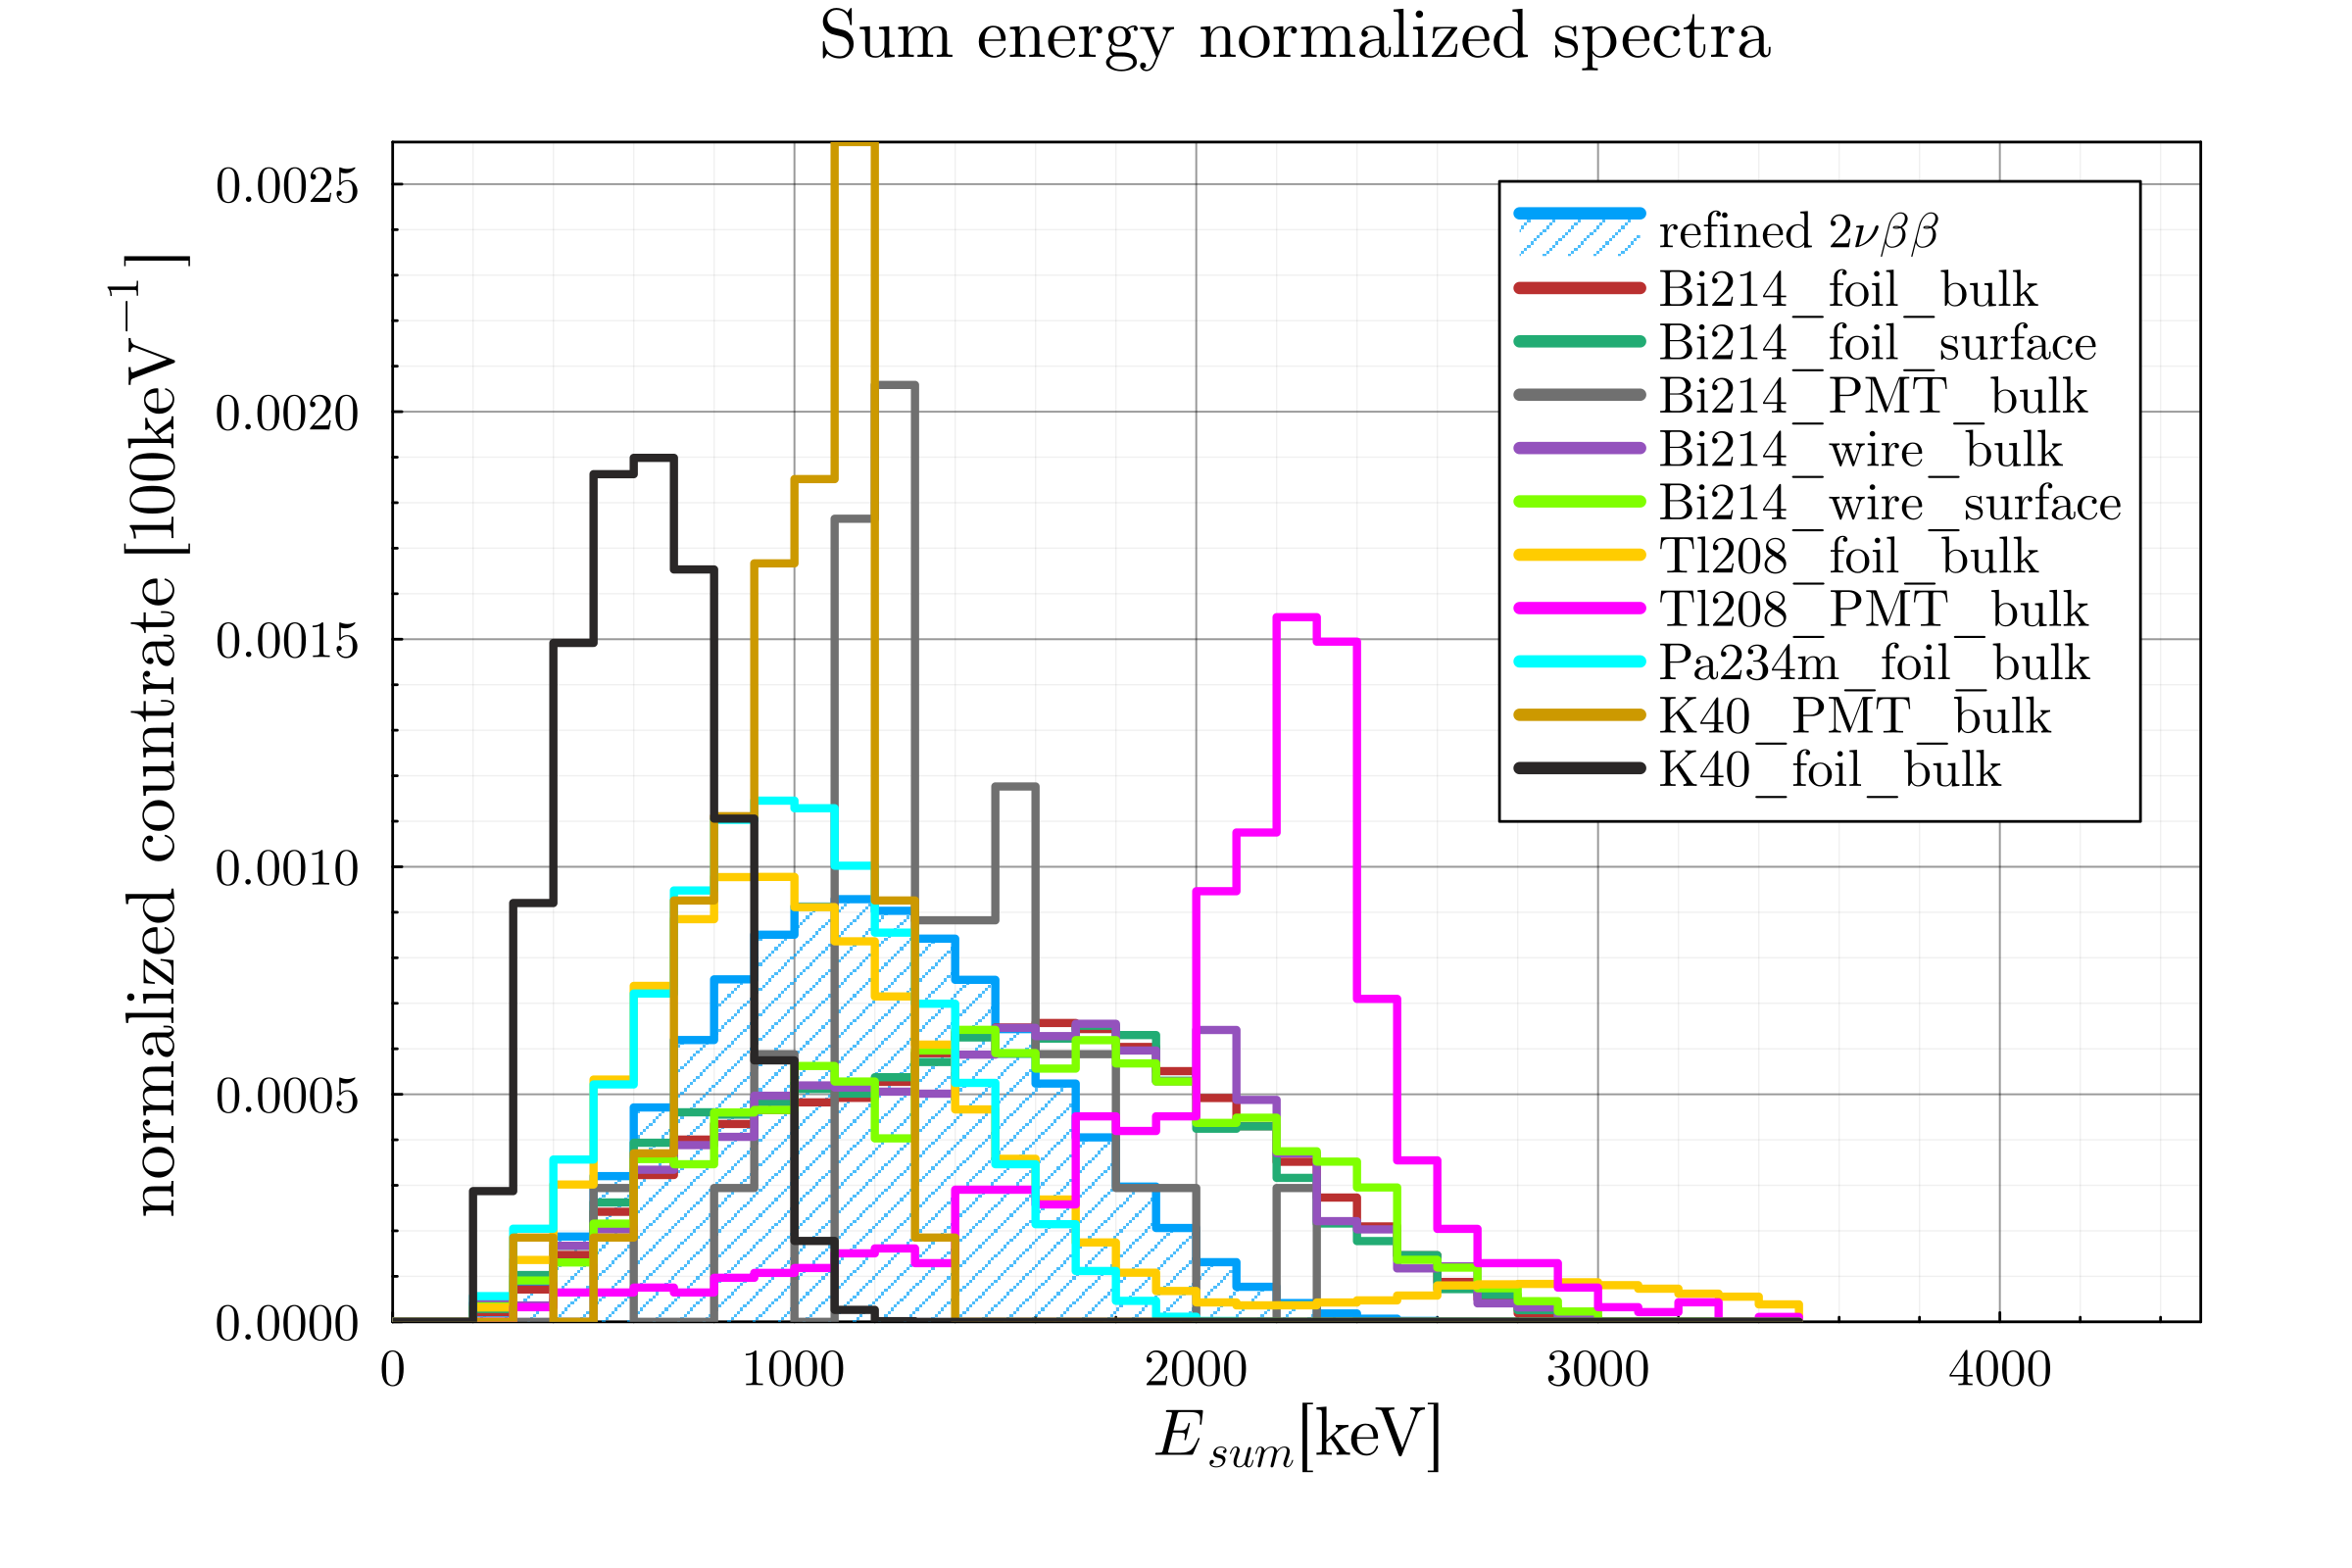

In [87]:
with(

        legend =:best, 
        bins = sumEParams[:binning], 
        thickness_scaling = 1.4,
        lw = 4,
        right_margin=12Plots.mm,
        size =(1200, 800),
        norm = :true,
        title = "Sum energy normalized spectra",
    ) do
    
    stephist(
        Xi037_foil_bulk.reconstructedEnergy1 .+ Xi037_foil_bulk.reconstructedEnergy2,
        label = "refined "*L"2\nu\beta\beta", 
        fill =0, 
        fa = 0.7, 
        fillstyle = :cross
    )
    
    stephist!(
        Bi214_foil_bulk.reconstructedEnergy1 .+ Bi214_foil_bulk.reconstructedEnergy2,label = "Bi214_foil_bulk", 
    )
    stephist!(
        Bi214_foil_surface.reconstructedEnergy1 .+ Bi214_foil_surface.reconstructedEnergy2,label = "Bi214_foil_surface", 
    )
    stephist!(
        Bi214_PMT_bulk.reconstructedEnergy1 .+ Bi214_PMT_bulk.reconstructedEnergy2,label = "Bi214_PMT_bulk", 
    )
    stephist!(
        Bi214_wire_bulk.reconstructedEnergy1 .+ Bi214_wire_bulk.reconstructedEnergy2,label = "Bi214_wire_bulk", 
    )
    stephist!(
        Bi214_wire_surface.reconstructedEnergy1 .+ Bi214_wire_surface.reconstructedEnergy2,label = "Bi214_wire_surface", 
    )
    stephist!(
        Tl208_foil_bulk.reconstructedEnergy1 .+ Tl208_foil_bulk.reconstructedEnergy2,label = "Tl208_foil_bulk", 
    )
    stephist!(
        Tl208_PMT_bulk.reconstructedEnergy1 .+ Tl208_PMT_bulk.reconstructedEnergy2,label = "Tl208_PMT_bulk", 
    )
    stephist!(
        Pa234m_foil_bulk.reconstructedEnergy1 .+ Pa234m_foil_bulk.reconstructedEnergy2,label = "Pa234m_foil_bulk", 
    )
    stephist!(
        K40_PMT_bulk.reconstructedEnergy1 .+ K40_PMT_bulk.reconstructedEnergy2,label = "K40_PMT_bulk", 
    )
    stephist!(
        K40_foil_bulk.reconstructedEnergy1 .+ K40_foil_bulk.reconstructedEnergy2,label = "K40_foil_bulk", 
        xlabel = L"E_{sum} "*"[keV]", 
        ylabel = "normalized countrate " *L"[%$(step(sumEParams[:binning])) \textrm{keV^{-1}}]", 
        xlims = (0,4500),
        
    )

    safesave(plotsdir("SumE", "Normalized_hist_total_spectrum.pdf"), current())
    safesave(plotsdir("SumE", "Normalized_hist_total_spectrum.png"), current())
    
    current()
end

 
### Now the estimated total spectrum as would be seen by SuperNEMO:
The estimated **total** counts for the full spectrum for each process can be calculated as:
 ``n = A * t * m * \varepsilon``

With the previously summarized parameters this is:
 

In [54]:
function get_isotope_details( activityParams, SNParams, simParams, isotope, dfData )
    a = activityParams[isotope]
    m = if( occursin("foil_bulk", string(isotope)))
        SNParams["foilMass"]
    elseif( occursin("surface", string(isotope)))
        SNParams["gasVolume"]
    elseif( occursin("PMT_bulk", string(isotope)))
        SNParams["PMTGlassMass"]
    elseif( occursin("wire_bulk", string(isotope)))
        SNParams["wireBulkMass"]
    end
    t = SNParams["t"]
    nTotSim = simParams[isotope]
    ε = nrow(dfData) / nTotSim

    nExpTot = a*m*t*ε

    return a, m, t, ε, nExpTot, nTotSim 
end
    
        

get_isotope_details (generic function with 1 method)

In [55]:
function print_isotope_details( activityParams, SNParams, simParams, isotope, dfData )
    (a, m, t, ε, nExpTot, nTotSim) = get_isotope_details( activityParams, SNParams, simParams, isotope, dfData ) 

    a = round(a, sigdigits=3)
    ε = round(ε*100, sigdigits=3)
    m = round(m, sigdigits=3)
    nExpTot = round(nExpTot, sigdigits=3)
    
    "|$isotope | $nExpTot | $ε | $a | $m |"
end

print_isotope_details (generic function with 1 method)

In [56]:
begin
    isotope_df = DataFrame()
    bkgIsotopes = [
        :Bi214_foil_bulk,
        :Bi214_foil_surface,
        :Bi214_PMT_bulk,
        :Bi214_wire_bulk,
        :Bi214_wire_surface,
        :Tl208_foil_bulk,
        :Tl208_PMT_bulk,
        :Pa234m_foil_bulk,
        :K40_foil_bulk,
        :K40_PMT_bulk,
    ]
    bkgDfs = [        
        Bi214_foil_bulk,
        Bi214_foil_surface,
        Bi214_PMT_bulk,
        Bi214_wire_bulk,
        Bi214_wire_surface,
        Tl208_foil_bulk,
        Tl208_PMT_bulk,
        Pa234m_foil_bulk,
        K40_foil_bulk,
        K40_PMT_bulk,
    ]
    for (i, d) in zip(bkgIsotopes, bkgDfs)
        (a, m, t, ε, nExpTot, nTotSim) = get_isotope_details( BkgActivityParams, SNparams, SimulationParams, i, d )
        push!(isotope_df, (isotope = string(i), n_expected = Measurements.value(nExpTot), ε = ε*100, activity = Measurements.value(a), amount = m, n_simulated = nTotSim), promote=:true)
    end

    (a, m, t, ε, nExpTot, nTotSim) = get_isotope_details( SigActivityParams, SNparams, SimulationParams, :Xi037_foil_bulk, Xi037_foil_bulk )
    push!(isotope_df, (isotope = string(:Xi037_foil_bulk), n_expected = Measurements.value(nExpTot), ε = ε*100, activity = Measurements.value(a), amount = m, n_simulated = nTotSim), promote=:true)
    
    isotope_df
    
    # header = (
    # ["isotope", "expected counts", L"\varepsilon", "activity", "amount", "simulated events"],
    # ["", " ", "[%]", "[Bq/amount]", L"[\textrm{kg or m^3 or l}]", " "]
    # )
    # pretty_table(
    #     isotope_df,
    #     header =header,
    #     backend = Val(:markdown)
    # )
end

11×6 DataFrame
 Row │ isotope             n_expected   ε         activity  amount   n_simulat ⋯
     │ String              Float64      Float64   Float64   Float64  Float64   ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Bi214_foil_bulk       240.794    0.162891  0.0003       6.25        1.0 ⋯
   2 │ Bi214_foil_surface    220.702    0.03888   0.00015     48.0         1.0
   3 │ Bi214_PMT_bulk      37527.8      0.00034   0.48951    286.0         1.0
   4 │ Bi214_wire_bulk         3.49104  0.02214   1.0e-5      20.0         1.0
   5 │ Bi214_wire_surface     99.9628   0.01761   0.00015     48.0         1.0 ⋯
   6 │ Tl208_foil_bulk        26.4097   0.099253  5.4e-5       6.25        1.0
   7 │ Tl208_PMT_bulk      30355.0      0.00093   0.144755   286.0         1.0
   8 │ Pa234m_foil_bulk    14434.1      0.169323  0.0173       6.25        1.0
   9 │ K40_foil_bulk       11629.1      0.040205  0.0587       6.25        1.0 ⋯
  10 │ K40_PMT_bulk        17753.2      5.4e-5    1.45804    286.0         1.0
  11 │ Xi037_foil_bulk     60904.8      8.24012   0.0015       6.25        1.0
                                                                1 column omitted

In [57]:
#scale histogram to estimated counts
function estimated_counts_hist1D(dataDf, activity, amount, time, binning, nTotalSim)
    totEff = nrow(dataDf) / nTotalSim
    h1d = 
        Hist1D(
            dataDf.reconstructedEnergy1 .+ dataDf.reconstructedEnergy2 ,
            binning
        )
    
    h1d = normalize(h1d) * step(binning) # normalize to area of 1
    
    if(typeof(activity)<:Measurement) # just a precaution, sometime I use activities with uncertainty
        activity = activity.val
    end
    
    h1d.hist.weights = h1d.hist.weights .*(
        activity * time * amount * totEff    
    ) # multiply each bin by activity * time * amount * totalEfficiency

    return h1d
end
    

estimated_counts_hist1D (generic function with 1 method)

┌ Warning: Mapping to the storage type failed; perhaps your data had out-of-range values?
│ Try `map(clamp01nan, img)` to clamp values to a valid range.
└ @ ImageMagick ~/.julia/packages/ImageMagick/KDZC2/src/ImageMagick.jl:179
┌ Warning: Mapping to the storage type failed; perhaps your data had out-of-range values?
│ Try `map(clamp01nan, img)` to clamp values to a valid range.
└ @ ImageMagick ~/.julia/packages/ImageMagick/KDZC2/src/ImageMagick.jl:179


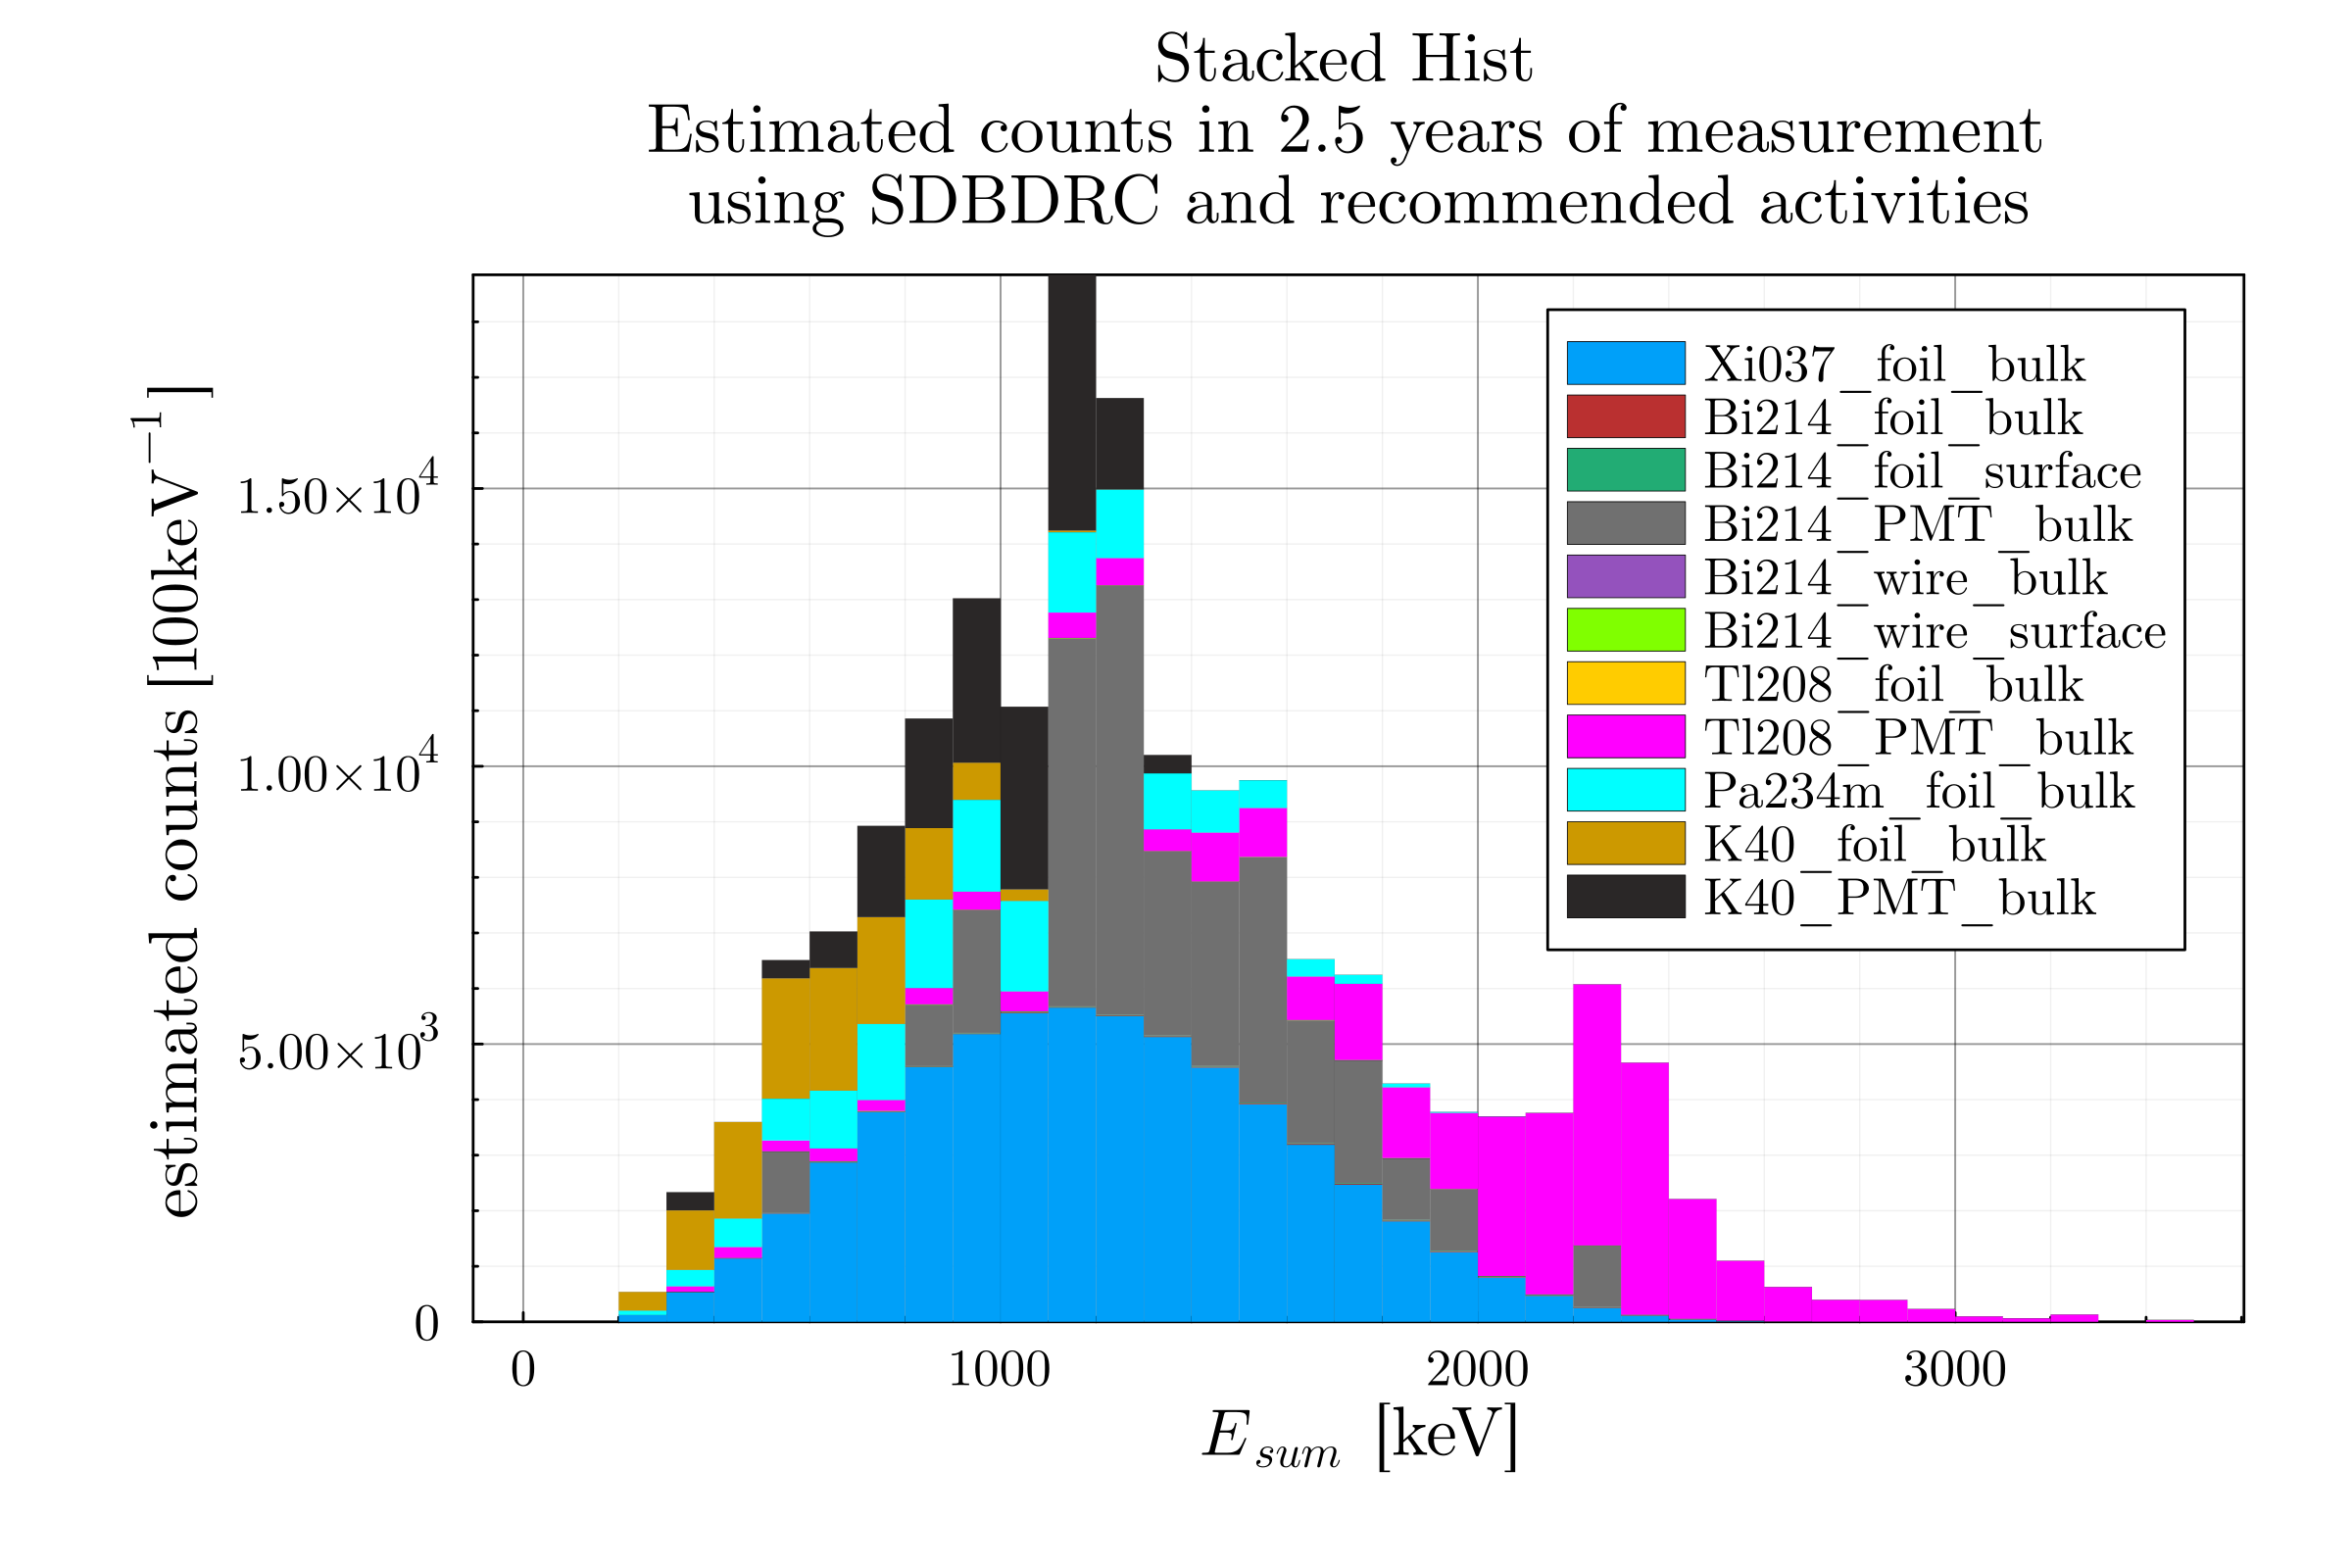

In [77]:
begin 
    # First we normalize histograms to probability
    h1Xi037_foil_bulk = estimated_counts_hist1D( 
        Xi037_foil_bulk, 
        SigActivityParams[:Xi037_foil_bulk], 
        SNparams["foilMass"], 
        SNparams["t"], 
        sumEParams[:binning], 
        SimulationParams[:Xi037_foil_bulk] 
    )

    h1Bi214_foil_bulk = estimated_counts_hist1D( 
        Bi214_foil_bulk, 
        BkgActivityParams[:Bi214_foil_bulk], 
        SNparams["foilMass"], 
        SNparams["t"], 
        sumEParams[:binning], 
        SimulationParams[:Bi214_foil_bulk] 
    )

    h1Bi214_foil_surface = estimated_counts_hist1D( 
        Bi214_foil_surface, 
        BkgActivityParams[:Bi214_foil_surface], 
        SNparams["gasVolume"], 
        SNparams["t"], 
        sumEParams[:binning], 
        SimulationParams[:Bi214_foil_surface] 
    )

    h1Bi214_PMT_bulk = estimated_counts_hist1D( 
        Bi214_PMT_bulk, 
        BkgActivityParams[:Bi214_PMT_bulk], 
        SNparams["PMTGlassMass"], 
        SNparams["t"], 
        sumEParams[:binning], 
        SimulationParams[:Bi214_PMT_bulk] 
    )

    h1Bi214_wire_bulk = estimated_counts_hist1D( 
        Bi214_wire_bulk, 
        BkgActivityParams[:Bi214_wire_bulk], # dummy activity
        SNparams["wireBulkMass"], 
        SNparams["t"], 
        sumEParams[:binning], 
        SimulationParams[:Bi214_wire_bulk] 
    )

    h1Bi214_wire_surface = estimated_counts_hist1D( 
        Bi214_wire_surface, 
        BkgActivityParams[:Bi214_foil_surface], 
        SNparams["gasVolume"], 
        SNparams["t"], 
        sumEParams[:binning], 
        SimulationParams[:Bi214_wire_surface] 
    )

    h1Tl208_foil_bulk = estimated_counts_hist1D( 
        Tl208_foil_bulk, 
        BkgActivityParams[:Tl208_foil_bulk], 
        SNparams["foilMass"], 
        SNparams["t"], 
        sumEParams[:binning], 
        SimulationParams[:Tl208_foil_bulk] 
    )

    h1Tl208_PMT_bulk = estimated_counts_hist1D( 
        Tl208_PMT_bulk, 
        BkgActivityParams[:Tl208_PMT_bulk], 
        SNparams["PMTGlassMass"], 
        SNparams["t"], 
        sumEParams[:binning], 
        SimulationParams[:Tl208_PMT_bulk] 
    )

    h1Pa234m_foil_bulk = estimated_counts_hist1D( 
        Pa234m_foil_bulk, 
        BkgActivityParams[:Pa234m_foil_bulk], 
        SNparams["foilMass"], 
        SNparams["t"], 
        sumEParams[:binning], 
        SimulationParams[:Pa234m_foil_bulk] 
    )

    h1K40_foil_bulk = estimated_counts_hist1D( 
        K40_foil_bulk, 
        BkgActivityParams[:K40_foil_bulk], 
        SNparams["foilMass"], 
        SNparams["t"], 
        sumEParams[:binning], 
        SimulationParams[:K40_foil_bulk] 
    )

    h1K40_PMT_bulk = estimated_counts_hist1D( 
        K40_PMT_bulk, 
        BkgActivityParams[:K40_PMT_bulk], 
        SNparams["PMTGlassMass"], 
        SNparams["t"], 
        sumEParams[:binning], 
        SimulationParams[:K40_PMT_bulk] 
    )

    histos = [
        h1Xi037_foil_bulk,
        h1Bi214_foil_bulk,
        h1Bi214_foil_surface,
        h1Bi214_PMT_bulk,
        h1Bi214_wire_bulk,
        h1Bi214_wire_surface,
        h1Tl208_foil_bulk,
        h1Tl208_PMT_bulk,
        h1Pa234m_foil_bulk,
        h1K40_foil_bulk,
        h1K40_PMT_bulk,
    ]
    isoNames = [
        "Xi037_foil_bulk",
        "Bi214_foil_bulk",
        "Bi214_foil_surface",
        "Bi214_PMT_bulk",
        "Bi214_wire_bulk",
        "Bi214_wire_surface",
        "Tl208_foil_bulk",
        "Tl208_PMT_bulk",
        "Pa234m_foil_bulk",
        "K40_foil_bulk",
        "K40_PMT_bulk",
    ]

    shTotal = SensitivityModule.stackedhist( 
        histos, 
        label = reshape(isoNames, (1, length(isoNames))),
        xlabel = L"E_{sum}"*" [keV]",
        ylabel = "estimated counts " *L"[%$(step(sumEParams[:binning])) \textrm{keV^{-1}}]",
        title = "Stacked Hist \nEstimated counts in $(SNparams["tYear"]) years of measurement \nusing SDBDRC and recommended activities"
    )

    safesave(plotsdir("SumE", "Stacked_hist_total_spectrum.pdf"), shTotal)
    safesave(plotsdir("SumE", "Stacked_hist_total_spectrum.png"), shTotal)
    
    display(shTotal)
end

┌ Warning: Mapping to the storage type failed; perhaps your data had out-of-range values?
│ Try `map(clamp01nan, img)` to clamp values to a valid range.
└ @ ImageMagick ~/.julia/packages/ImageMagick/KDZC2/src/ImageMagick.jl:179
┌ Warning: Mapping to the storage type failed; perhaps your data had out-of-range values?
│ Try `map(clamp01nan, img)` to clamp values to a valid range.
└ @ ImageMagick ~/.julia/packages/ImageMagick/KDZC2/src/ImageMagick.jl:179


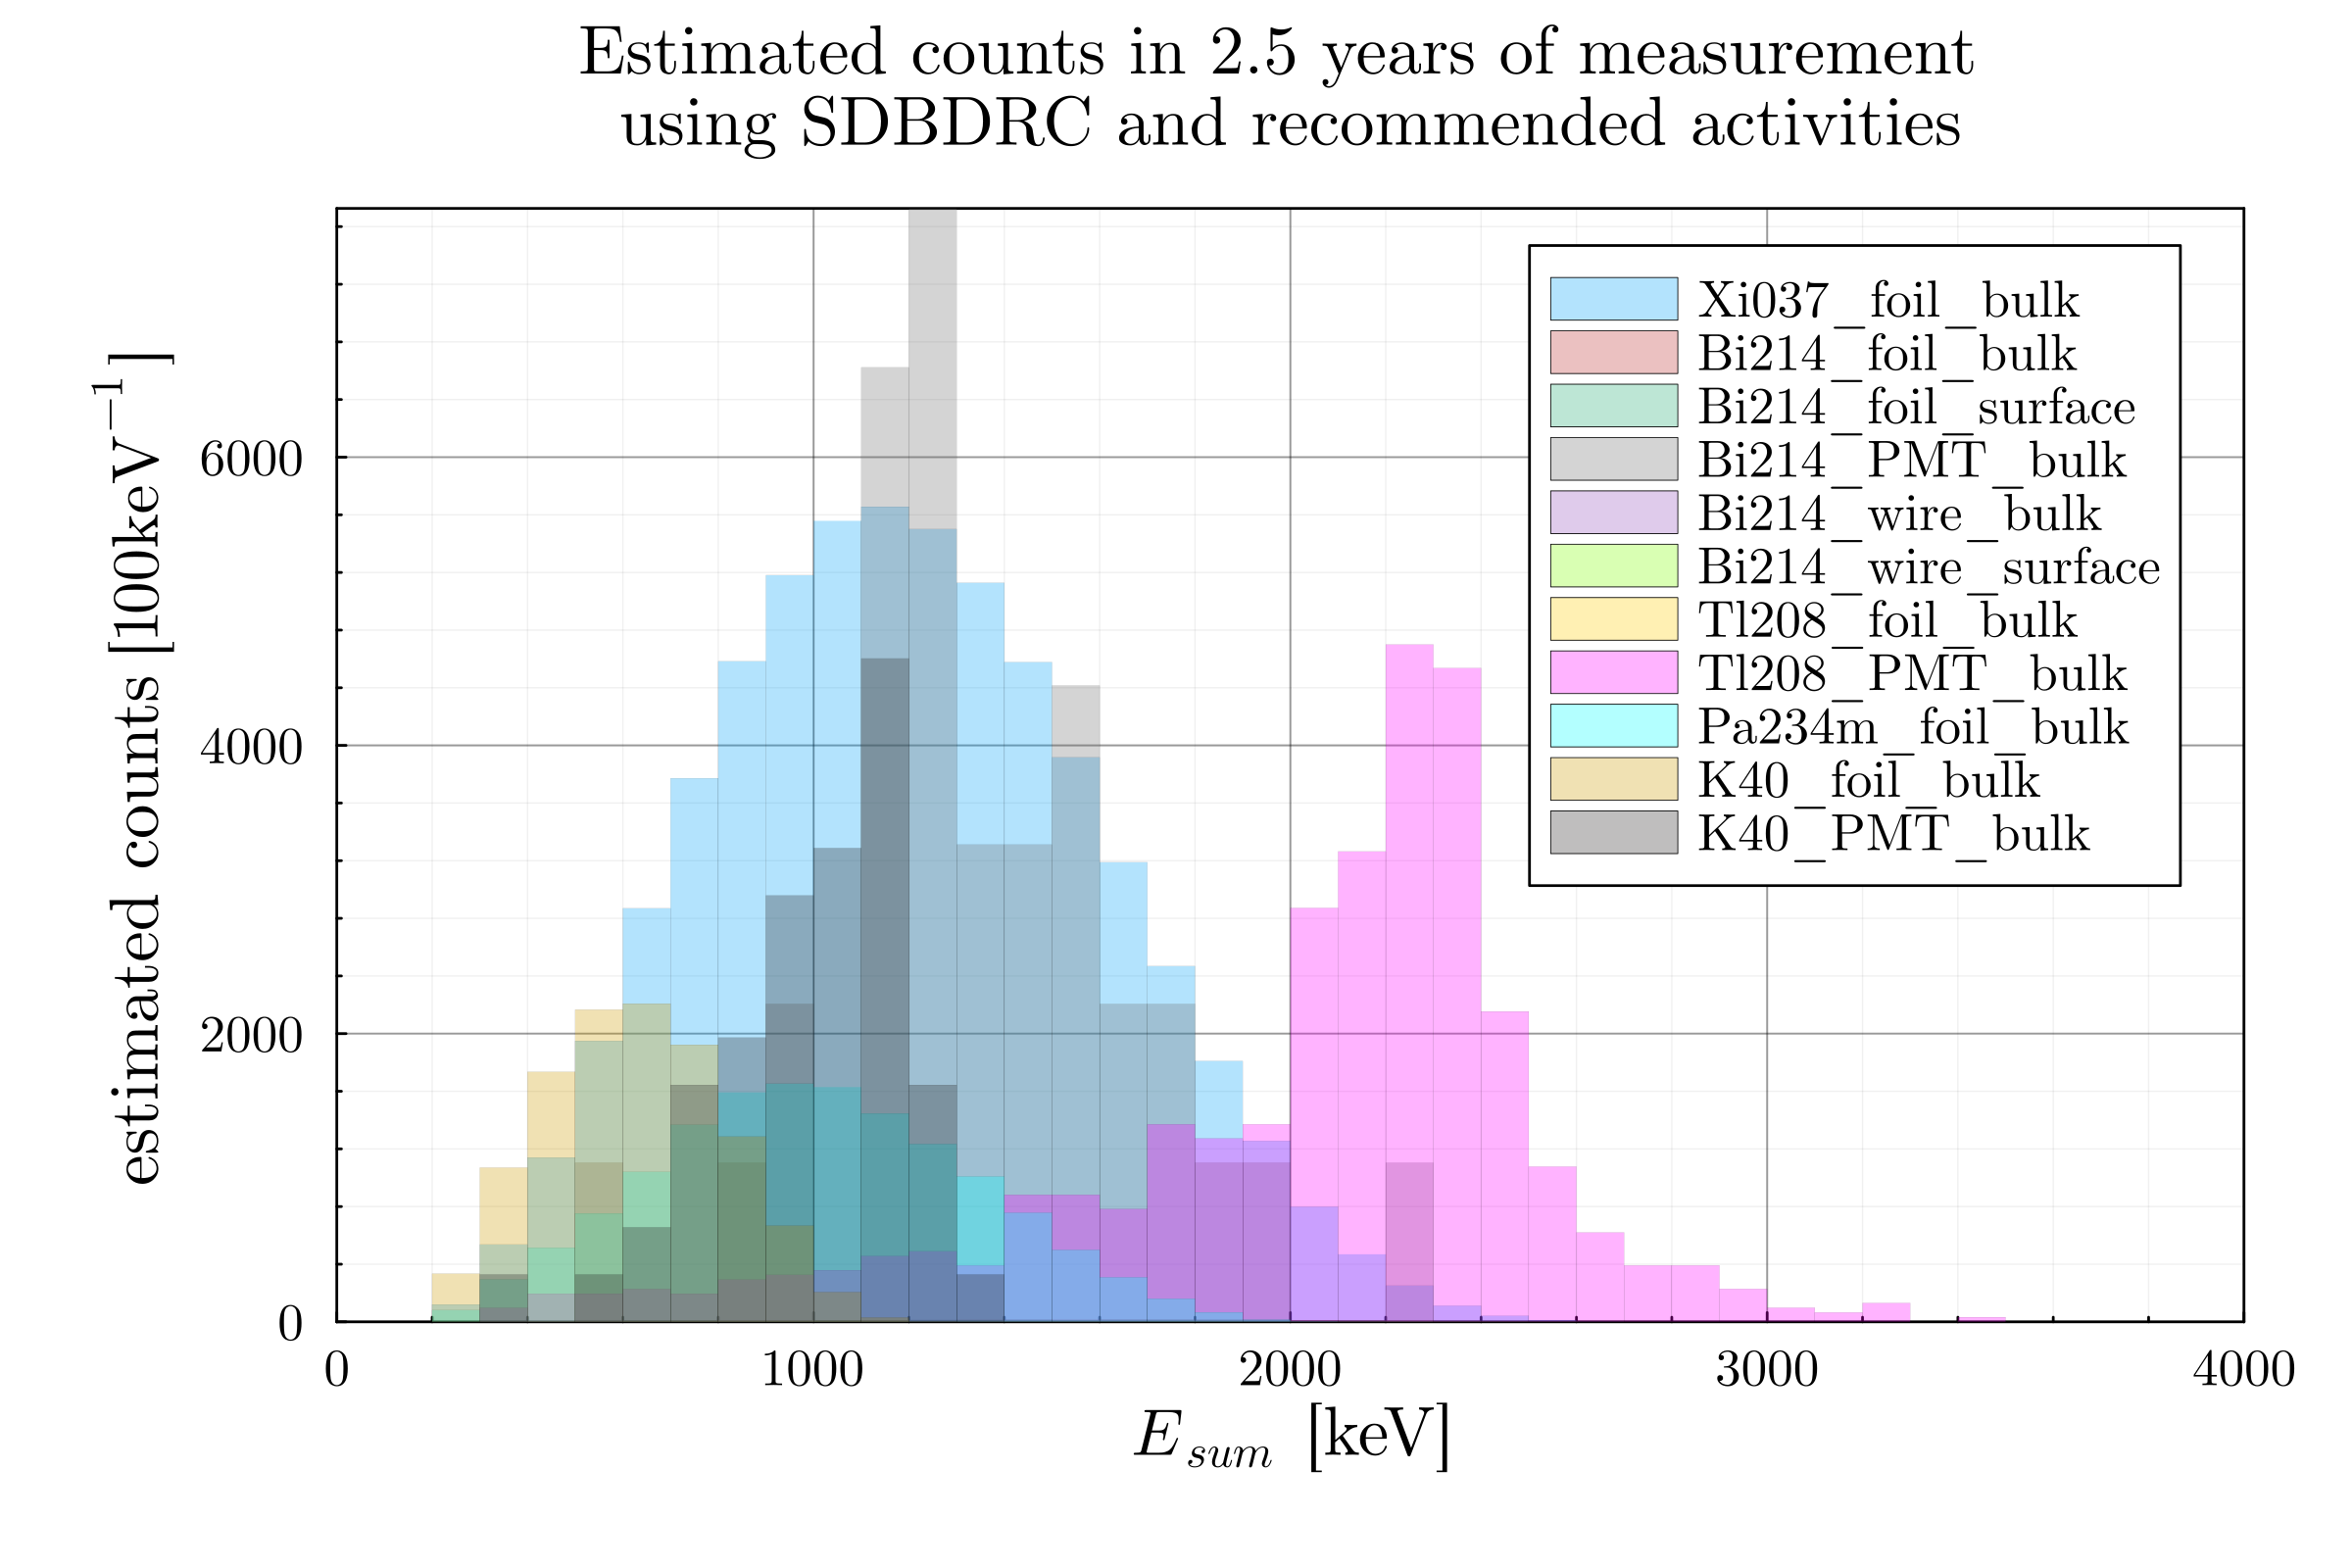

In [78]:
begin
    p = plot(
        xlabel = L"E_{sum}"*" [keV]",
        ylabel = "estimated counts " *L"[%$(step(sumEParams[:binning])) \textrm{keV^{-1}}]",
        title = "Estimated counts in $(SNparams["tYear"]) years of measurement \nusing SDBDRC and recommended activities",
        xlims = (0, 4000)
    )
    for i in 1:length(histos)
    plot!(p, 
        histos[i], fa = 0.3, lw = 0, label = isoNames[i]
        #midpoints(binedges(h1Xi037_foil_bulk)), bincounts(h1Xi037_foil_bulk), st = :step, l = names[1] 
    )
    end
    

    safesave(plotsdir("SumE", "hist_total_spectrum.pdf"), p)
    safesave(plotsdir("SumE", "hist_total_spectrum.png"), p)
    
    p
end


 
## Analysis

To perform the analysis as described in `docdb:5833`. We must follow the steps: 
1. calculate the efficiency maps
2. calculate the corresponding s/b ratios
3. determine best ROI
4. extract ``\bar{b}`` and ``\varepsilon`` in the ROI 
5. calculate ``T_{1/2}``

In this analysis, I've created a data-type `Process` which holds the information about the individual studied processes and I've written a number of methods which calculate the efficiency maps, ROIs and T12. The following example shows the pipeline to obtain the T12:
 

 
First we instantiate the `Process`'s for each isotope:
 

In [62]:
begin
    Bi214_foil_bulk_SumE    = 
        Process(Bi214_foil_bulk.reconstructedEnergy1 .+ Bi214_foil_bulk.reconstructedEnergy2, sumEBi214_foil_bulk_Params)
    
    Bi214_foil_surface_SumE = 
        Process(Bi214_foil_surface.reconstructedEnergy1 .+ Bi214_foil_surface.reconstructedEnergy2, sumEBi214_foil_surface_Params)
    
    Bi214_PMT_bulk_SumE     = 
        Process(Bi214_PMT_bulk.reconstructedEnergy1 .+ Bi214_PMT_bulk.reconstructedEnergy2, sumEBi214_PMT_bulk_Params)
    
    Bi214_wire_bulk_SumE    = 
        Process(Bi214_wire_bulk.reconstructedEnergy1 .+ Bi214_wire_bulk.reconstructedEnergy2, sumEBi214_wire_bulk_Params)
    
    Bi214_wire_surface_SumE = 
        Process(Bi214_wire_surface.reconstructedEnergy1 .+ Bi214_wire_surface.reconstructedEnergy2, sumEBi214_wire_surface_Params)
    
    
    Tl208_foil_bulk_SumE    = 
        Process(Tl208_foil_bulk.reconstructedEnergy1 .+ Tl208_foil_bulk.reconstructedEnergy2, sumETl208_foil_bulk_Params)
    
    Tl208_PMT_bulk_SumE     = 
        Process(Tl208_PMT_bulk.reconstructedEnergy1 .+ Tl208_PMT_bulk.reconstructedEnergy2, sumETl208_PMT_bulk_Params)
    
    
    Pa234m_foil_bulk_SumE   = 
        Process(Pa234m_foil_bulk.reconstructedEnergy1 .+ Pa234m_foil_bulk.reconstructedEnergy2, sumEPa234m_foil_bulk_Params)
    
    
    K40_foil_bulk_SumE      = 
        Process(K40_foil_bulk.reconstructedEnergy1 .+ K40_foil_bulk.reconstructedEnergy2, sumEK40_foil_bulk_Params)
    
    K40_PMT_bulk_SumE       = 
        Process(K40_PMT_bulk.reconstructedEnergy1 .+ K40_PMT_bulk.reconstructedEnergy2, sumEK40_PMT_bulk_Params)
    
    
    Xi037_foil_bulk_SumE     = 
        Process(Xi037_foil_bulk.reconstructedEnergy1 .+ Xi037_foil_bulk.reconstructedEnergy2, sumEXiParams)
    

    nothing # so there's no cell output
end

 
### At construction, the efficiency maps are created as well:
 

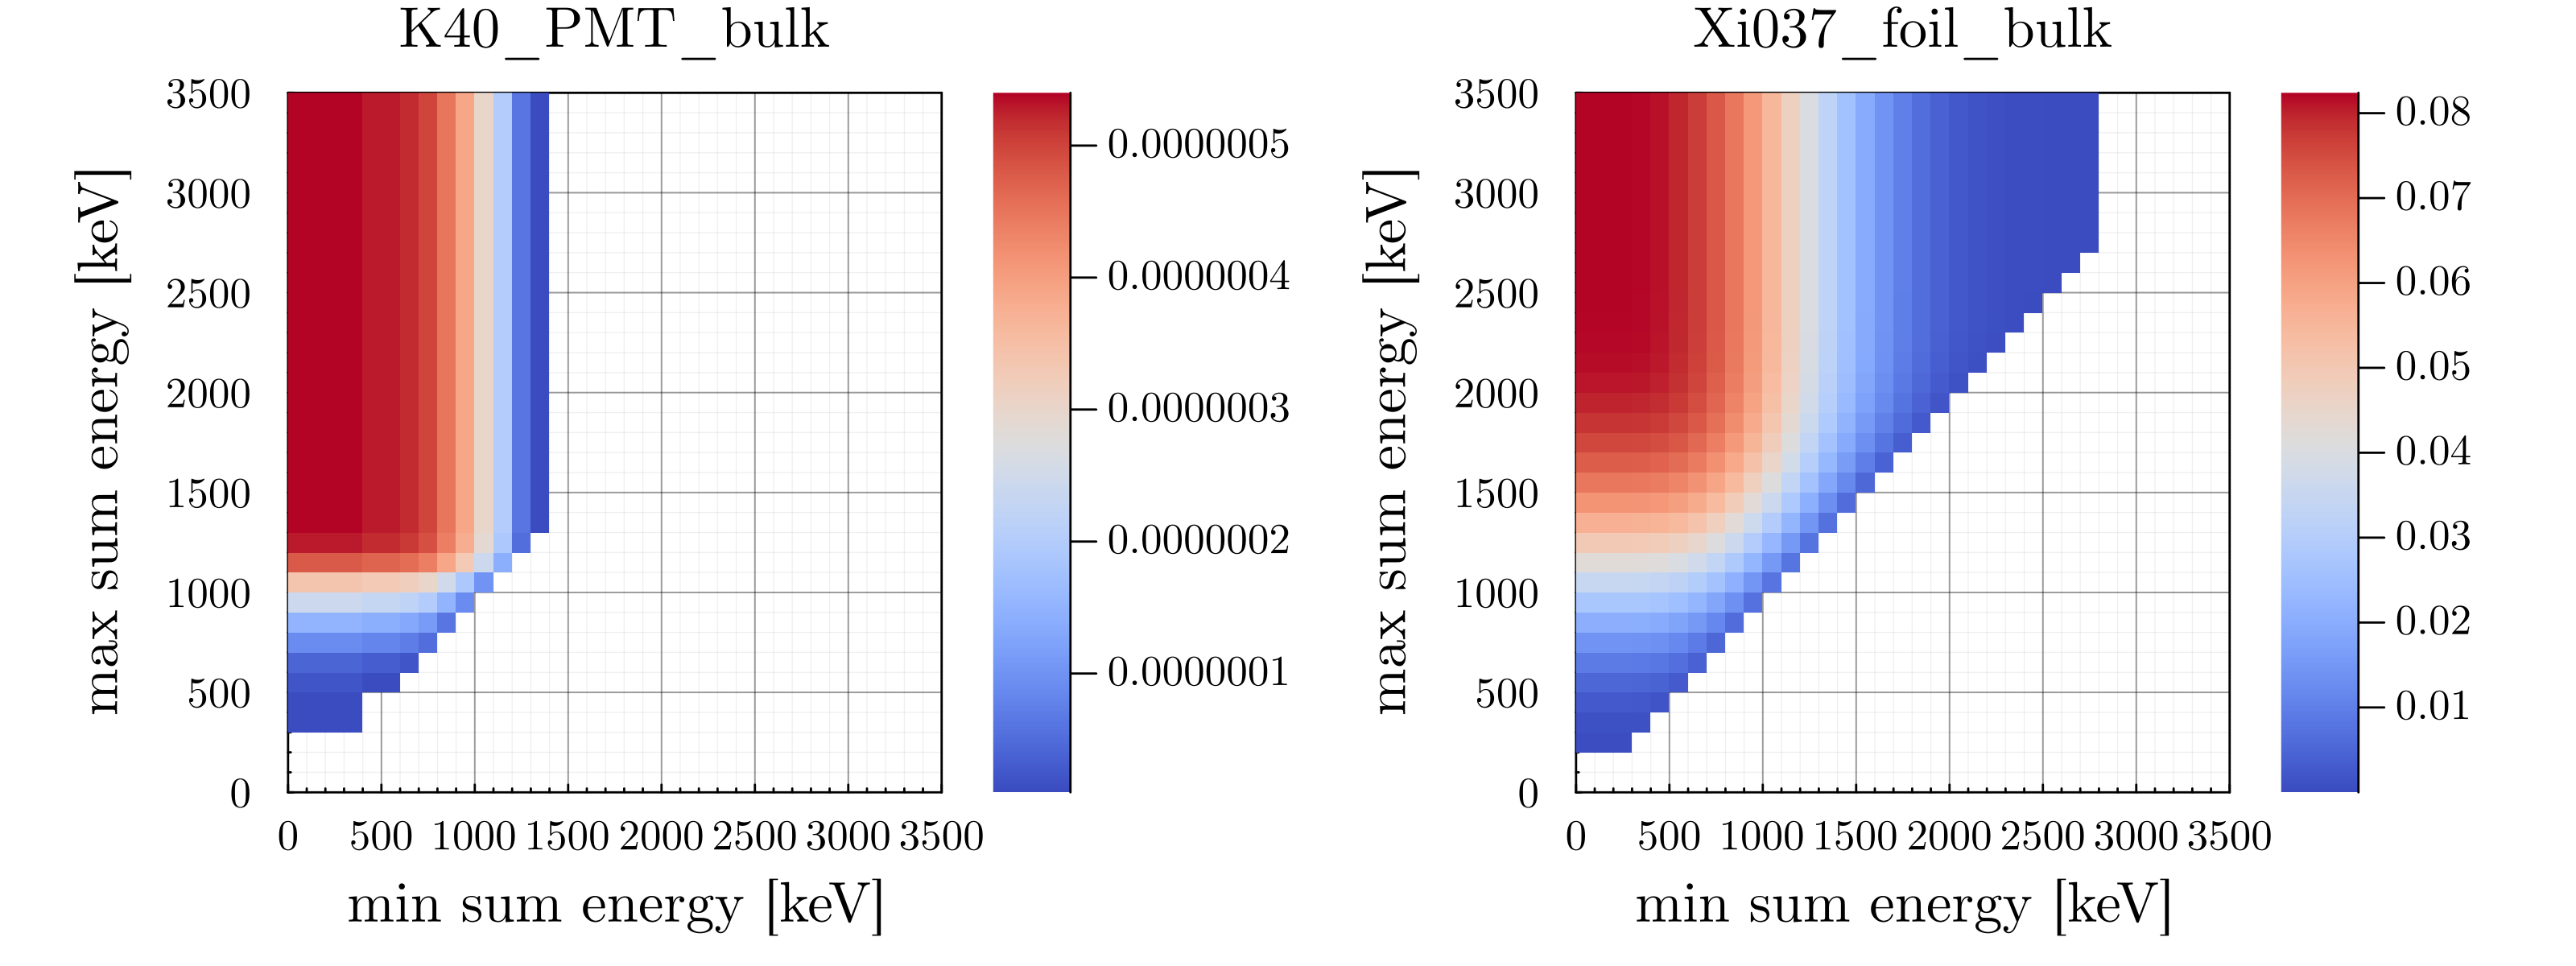

In [64]:
with(
    gr;

    c = :coolwarm, 
    size = (1600, 600), 
    thickness_scaling = 1.4, 
    right_margin = 8Plots.mm,
    left_margin = 8Plots.mm,
    bottom_margin = 8Plots.mm,
)   do
#Bi214
    p1 = plot(Bi214_foil_bulk_SumE.efficiency, title ="$(Bi214_foil_bulk_SumE.isotopeName)")

    p2 = plot(Bi214_foil_surface_SumE.efficiency, title ="$(Bi214_foil_surface_SumE.isotopeName)")

    p3 = plot(Bi214_wire_bulk_SumE.efficiency, title ="$(Bi214_wire_bulk_SumE.isotopeName)")

    p4 = plot(Bi214_wire_surface_SumE.efficiency, title ="$(Bi214_wire_surface_SumE.isotopeName)")

    p5 = plot(Bi214_PMT_bulk_SumE.efficiency, title ="$(Bi214_PMT_bulk_SumE.isotopeName)")


#Tl208   
    p6 = plot(Tl208_foil_bulk_SumE.efficiency, title ="$(Tl208_foil_bulk_SumE.isotopeName)")

    p7 = plot(Tl208_PMT_bulk_SumE.efficiency, title ="$(Tl208_PMT_bulk_SumE.isotopeName)")

#Pa234m
    p8 = plot(Pa234m_foil_bulk_SumE.efficiency, title ="$(Pa234m_foil_bulk_SumE.isotopeName)")

#K40
    p9 = plot(K40_foil_bulk_SumE.efficiency, title ="$(K40_foil_bulk_SumE.isotopeName)")

    p10 = plot(
        K40_PMT_bulk_SumE.efficiency, 
        title ="$(K40_PMT_bulk_SumE.isotopeName)",
        xlabel = "min sum energy [keV]", 
        ylabel = "max sum energy [keV]", 
    )

#Xi037
    p11 = plot(
        Xi037_foil_bulk_SumE.efficiency, 
        title ="$(Xi037_foil_bulk_SumE.isotopeName)", 
        xlabel = "min sum energy [keV]", 
        ylabel = "max sum energy [keV]", 
    )

    plot(p10, p11) # it's not viable to display 11 plots, just look at the saved pngs :P
end



#### Combining the **estimated** counts into the efficiency maps we can create the s/b maps:


In [66]:
stbSum = get_sToBRatio(
    Xi037_foil_bulk_SumE,
    Bi214_foil_bulk_SumE,
    Bi214_foil_surface_SumE,
    Bi214_PMT_bulk_SumE,
    Bi214_wire_bulk_SumE,
    Bi214_wire_surface_SumE,
    Tl208_foil_bulk_SumE,
    Tl208_PMT_bulk_SumE,
    Pa234m_foil_bulk_SumE,
    K40_foil_bulk_SumE,
    K40_PMT_bulk_SumE,
);

┌ Warning: get_bkg_rate(): passed isotope Xi037_foil_bulk is a signal process!!
└ @ SensitivityModule /sps/nemo/scratch/mpetro/Projects/SNSensitivityEstimate/src/Process.jl:112
┌ Warning: get_sig_rate(): passed isotope Bi214_foil_bulk is a background process!!
└ @ SensitivityModule /sps/nemo/scratch/mpetro/Projects/SNSensitivityEstimate/src/Process.jl:129
┌ Warning: get_sig_rate(): passed isotope Bi214_foil_surface is a background process!!
└ @ SensitivityModule /sps/nemo/scratch/mpetro/Projects/SNSensitivityEstimate/src/Process.jl:129
┌ Warning: get_sig_rate(): passed isotope Bi214_PMT_bulk is a background process!!
└ @ SensitivityModule /sps/nemo/scratch/mpetro/Projects/SNSensitivityEstimate/src/Process.jl:129
┌ Warning: get_sig_rate(): passed isotope Bi214_wire_bulk is a background process!!
└ @ SensitivityModule /sps/nemo/scratch/mpetro/Projects/SNSensitivityEstimate/src/Process.jl:129
┌ Warning: get_sig_rate(): passed isotope Bi214_wire_surface is a background process!!
└ @ Sensit

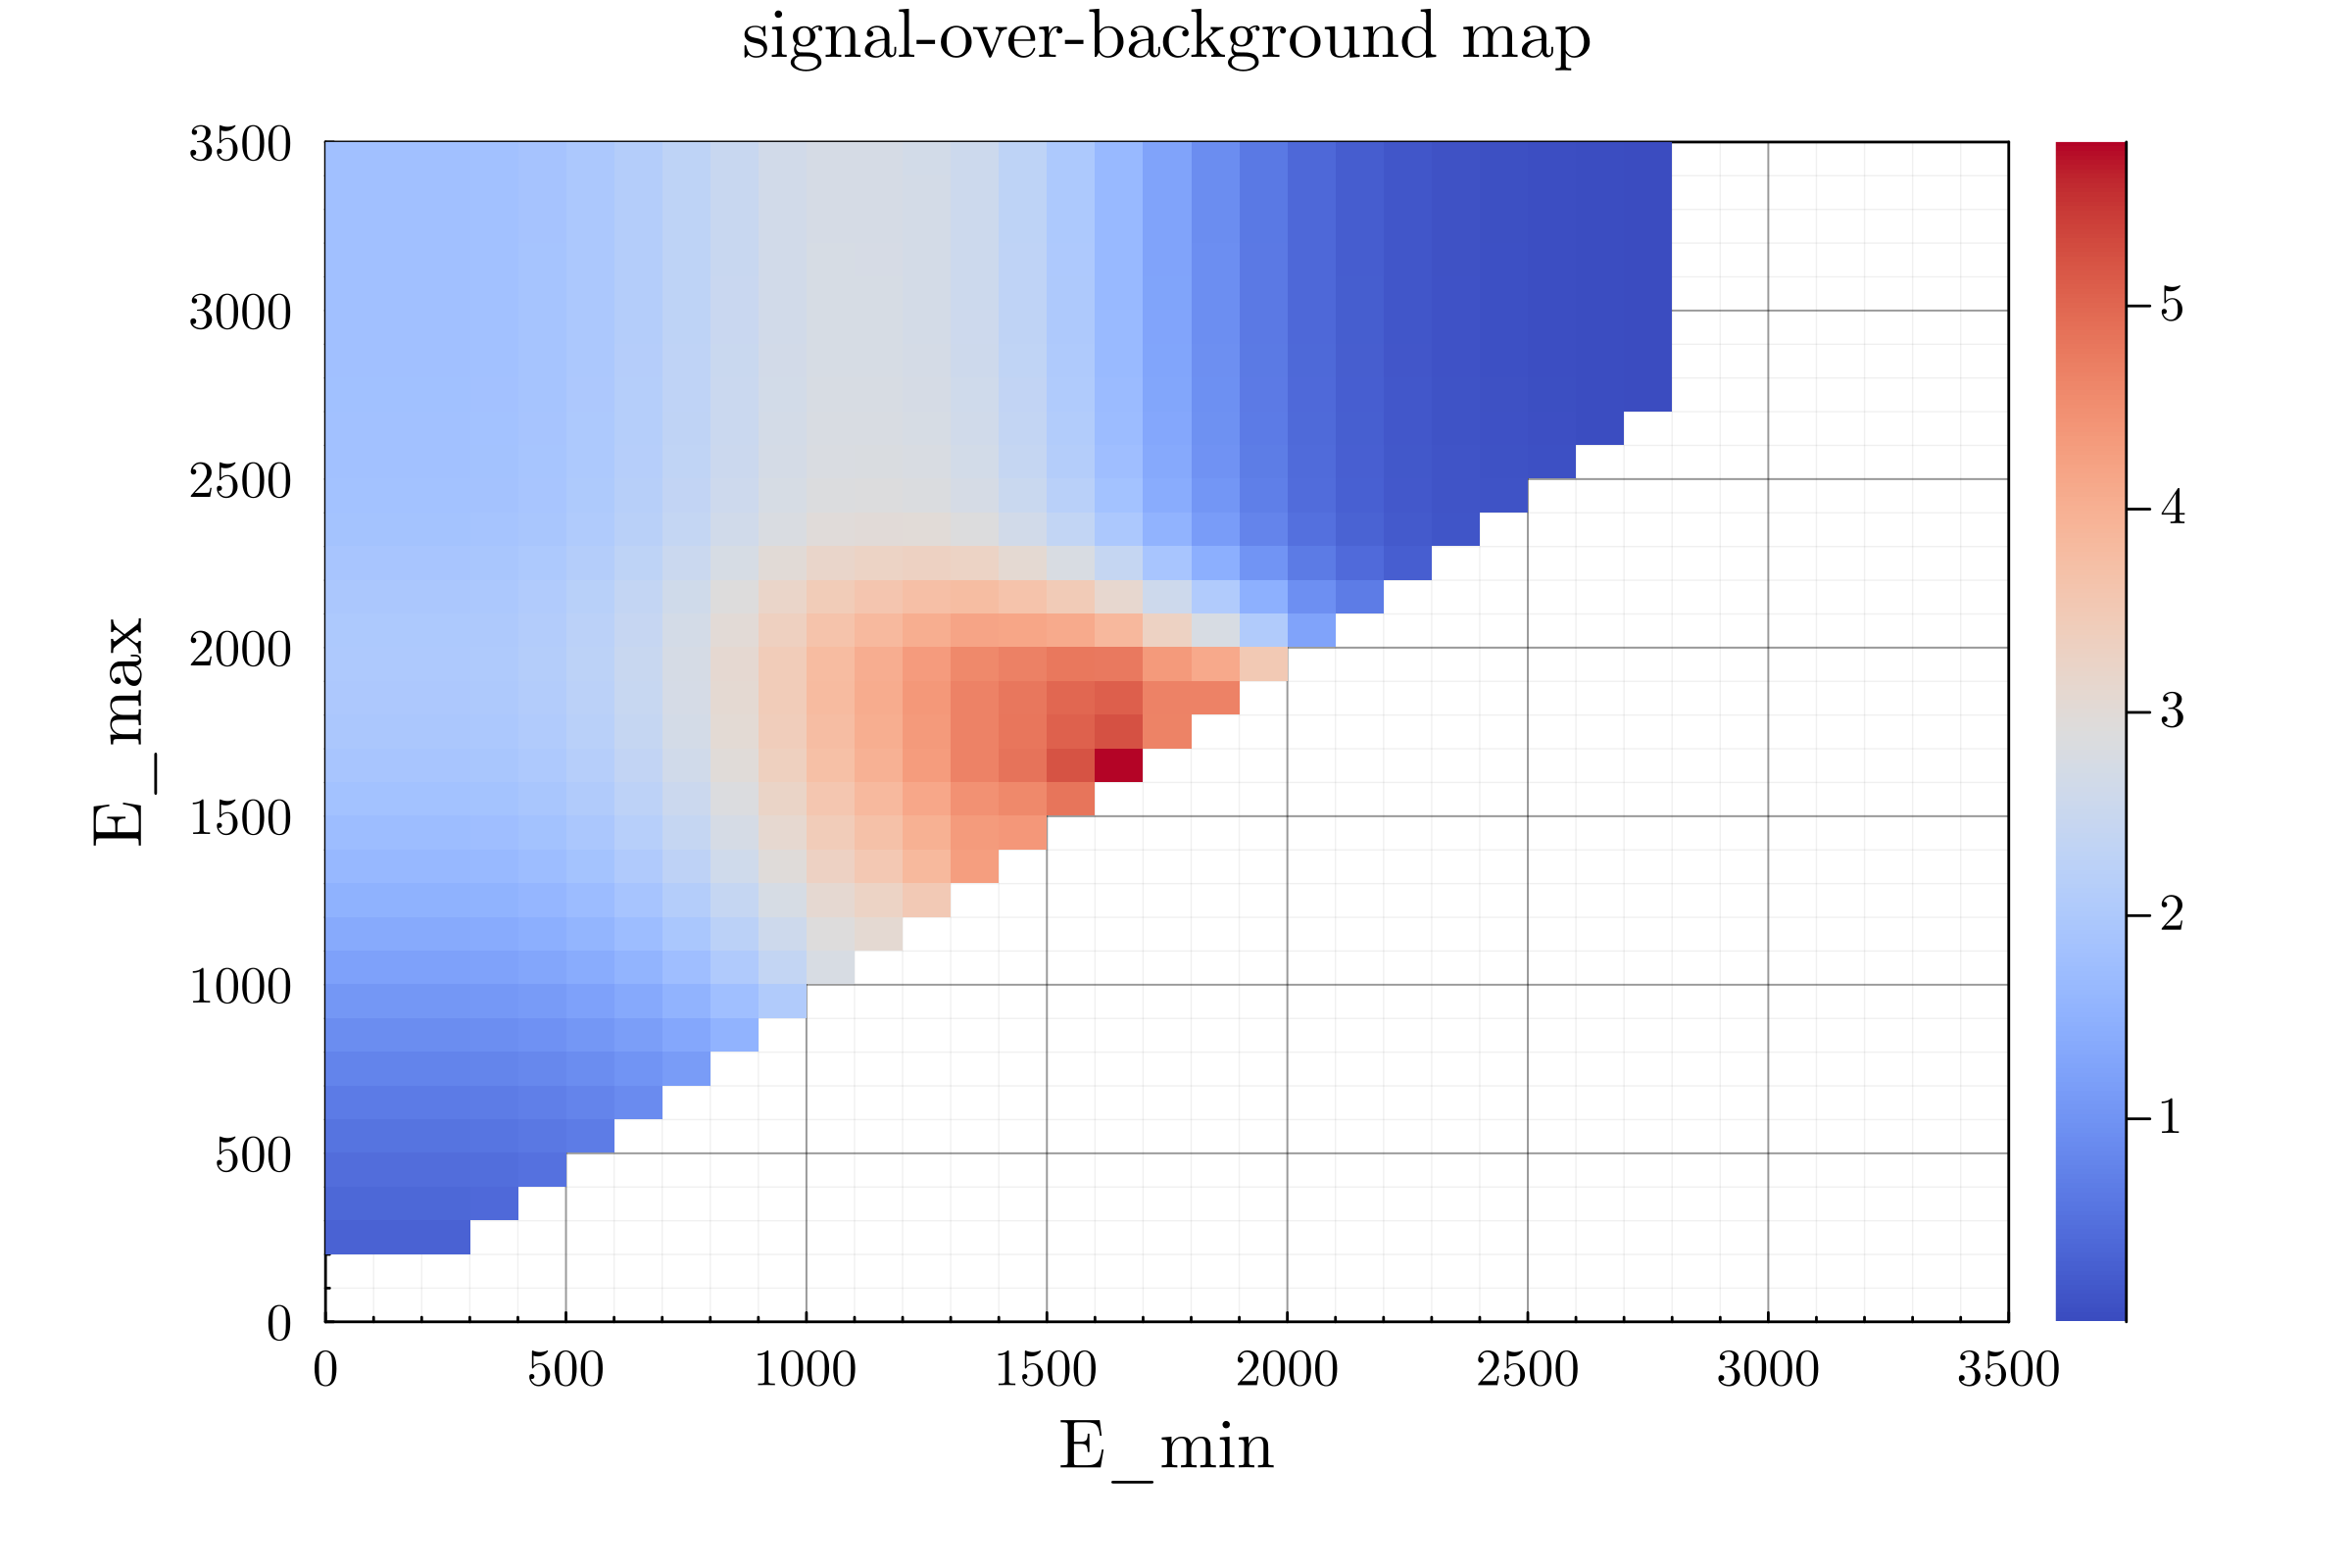

In [67]:
plot(
    stbSum, 
    c =:coolwarm, widen =:false,
    xlabel ="E_min", ylabel ="E_max",
    title= "signal-over-background map"
)

In [68]:
best_stbSum= get_max_bin(stbSum);

In [81]:
md"""
### Largest s/b value (best ROI) is found with: 
- ROI: ($(best_stbSum[:minBinEdge]) - $(best_stbSum[:maxBinEdge])) keV
- s/b: $(best_stbSum[:maxBinCount] |> round)
"""

### Largest s/b value (best ROI) is found with:

  * ROI: (1600.0 - 1700.0) keV
  * s/b: 6.0


In [70]:
expBkgESum = get_estimated_bkg_counts(
    best_stbSum, 
    SNparams, 
    Bi214_foil_bulk_SumE,
    Bi214_foil_surface_SumE,
    Bi214_PMT_bulk_SumE,
    Bi214_wire_bulk_SumE,
    Bi214_wire_surface_SumE,
    Tl208_foil_bulk_SumE,
    Tl208_PMT_bulk_SumE,
    Pa234m_foil_bulk_SumE,
    K40_foil_bulk_SumE,
    K40_PMT_bulk_SumE,
)


10389.9 ± 1.8

### The estimated background count in the ROI is: b = $(expBkgESum |> round)


In [72]:
effbb = lookup( Xi037_foil_bulk_SumE.efficiency, best_stbSum[:minBinEdge], best_stbSum[:maxBinEdge]);

In [83]:
md"""
### The corresponding signal efficiency in ROI is: $effbb
"""

### The corresponding signal efficiency in ROI is: 0.00765411


In [84]:
md""" 
### Finally the calculated sensitivity (assuming Gaussian approximation) for CL = 90% is: 
 ``$T_{1/2}^{2\nu} \geq (3.288 \pm 0.003)\cdot 10^{21} \textrm{yr}$``
"""
 

### Finally the calculated sensitivity (assuming Gaussian approximation) for CL = 90% is:

$$T_{1/2}^{2\nu} \geq (3.288 \pm 0.003)\cdot 10^{21} \textrm{yr}$$


In [75]:
ThalfbbESum = get_tHalf(SNparams, effbb, expBkgESum, 1.8)


3.2882e21 ± 2.8e17

  ✓ ImageFiltering


lld: error: cannot open output file /pbs/home/m/mpetro/.julia/compiled/v1.10/Makie/jl_c9936C: No space left on device
